# Plot-based Movie Genre Classification

This notebook presents an experiment relateed to one of the most common tasks in Natural Language Processing: text classification.

A movie genre classification based on plots is performed. The chosen dataset can be found at https://www.kaggle.com/jrobischon/wikipedia-movie-plots. This dataset contains plots (scraped from Wikipedia) of 34886 movies from many nationalities.

Two types of classification tasks are presented: multiclass and binary. The former considers the 10 most frequent genres in the dataset, while the latter considers only the two most frequent genres (drama and comedy).

The notebook presents a simple data exploratory analysis (since the focus is on the machine learning part) and all steps necessary for the classification task, from data preprocessing to the presentation of the final results along with a detailed analysis at the end. 

The final experiments on multiclass classification were performed in the Google Colab environment using its GPU resources. Due to resource availability issues, the final experiments on binary classification were performed using a Google Cloud Deep Learning VM with an NVIDIA Tesla K80 (the Google Colab runtime was connected to this VM).

In [5]:
import pandas as pd
import numpy as np
import ast
import string
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

import itertools

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Downloading the dataset

In [2]:
!pip install -q kaggle

!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d jrobischon/wikipedia-movie-plots

 30% 9.00M/29.9M [00:00<00:00, 27.0MB/s]
100% 29.9M/29.9M [00:00<00:00, 60.9MB/s]


In [3]:
!unzip ./wikipedia-movie-plots.zip

Archive:  ./wikipedia-movie-plots.zip
  inflating: wiki_movie_plots_deduped.csv  


## (Simple) Exploratory Data Analysis

In [6]:
df = pd.read_csv('/content/wiki_movie_plots_deduped.csv')
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [ ]:
df.shape

(34886, 8)

In [7]:
df.isna().sum()

Release Year           0
Title                  0
Origin/Ethnicity       0
Director               0
Cast                1422
Genre                  0
Wiki Page              0
Plot                   0
dtype: int64

In [8]:
df.describe(include='all')

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
count,34886.000000,34886,34886,34886,33464,34886,34886,34886
unique,NaN,32432,24,12593,32182,2265,34070,33869
top,NaN,The Three Musketeers,American,Unknown,Tom and Jerry,unknown,https://en.wikipedia.org/wiki/Himitsu_Sentai_G...,"(マッスル人参争奪！超人大戦争, Massuru Ninjin Soudatsu! Chou..."
freq,NaN,8,17377,1124,80,6083,5,6
mean,1981.314252,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,27.815174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1901.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,1957.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1988.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2007.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
len(np.unique(df['Genre']))

2265

There are too many genres to display. Let's show only the top 20.

Text(0, 0.5, '# movies')

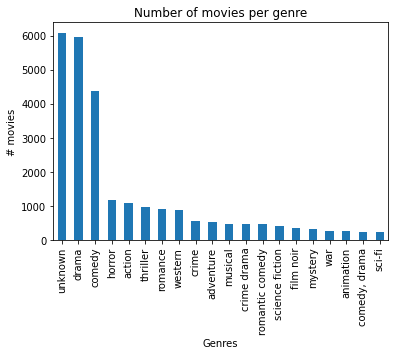

In [ ]:
df['Genre'].value_counts()[:20].plot.bar(title='Number of movies per genre')
plt.xlabel('Genres')
plt.ylabel('# movies')

Plotting the number of movies per origin/ethnicity.

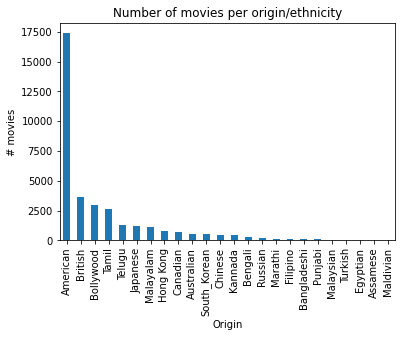

In [ ]:
df['Origin/Ethnicity'].value_counts().plot.bar(title='Number of movies per origin/ethnicity')
plt.xlabel('Origin')
plt.ylabel('# movies')
plt.show()

Plotting the number of movies per release year.

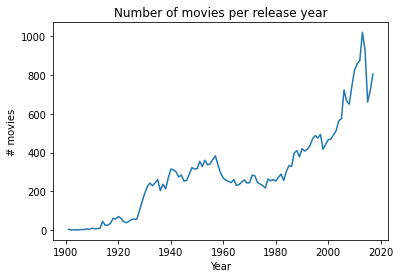

In [ ]:
df['Release Year'].value_counts().sort_index(ascending=True).plot.line(title='Number of movies per release year')
plt.xlabel('Year')
plt.ylabel('# movies')
plt.show()

Checking the most frequent words in the plots.

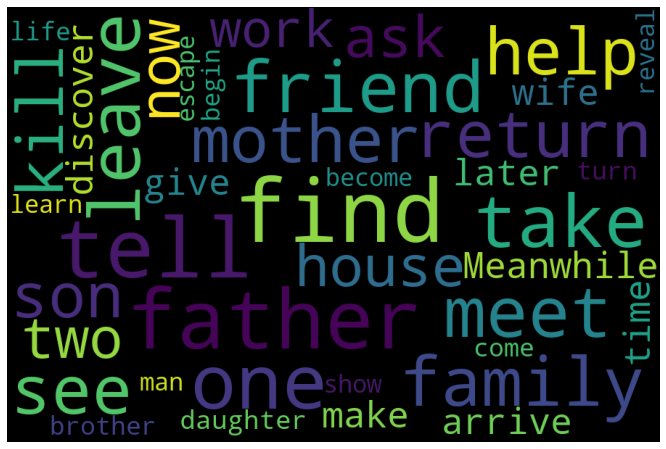

In [ ]:
wordcloud = WordCloud(width=900, height=900, max_font_size=120, max_words=80).generate(" ".join(df['Plot']))

plt.subplots(figsize=(16, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Data Preprocessing

We are only interested in two columns: Genre and Plot.

In [ ]:
df = df[['Genre', 'Plot']]
df.head()

,Genre,Plot
0,unknown,"A bartender is working at a saloon, serving dr..."
1,unknown,"The moon, painted with a smiling face hangs ov..."
2,unknown,"The film, just over a minute long, is composed..."
3,unknown,Lasting just 61 seconds and consisting of two ...
4,unknown,The earliest known adaptation of the classic f...


Checking the distribution of the top 10 genres (plus 'unknown').

In [ ]:
df['Genre'].value_counts()[:11]

unknown      6083
drama        5964
comedy       4379
horror       1167
action       1098
thriller      966
romance       923
western       865
crime         568
adventure     526
musical       467
Name: Genre, dtype: int64

The 'unknown' genre will not be taken into account, so let's drop all samples which were classified as unknown.

In [ ]:
df = df[df['Genre'] != 'unknown']
df['Genre'].value_counts()[:10]

drama        5964
comedy       4379
horror       1167
action       1098
thriller      966
romance       923
western       865
crime         568
adventure     526
musical       467
Name: Genre, dtype: int64

Now the plots are "cleaned". They are converted to lowercase, stopwords are removed as well as punctuations and finally, they are stemmed using Porter Stemmer in order to obtain the morphological essence (stem) of the words. The NLTK library suite was used and the stopwords come from its *corpus* package.

In [ ]:
ps = PorterStemmer()

def clean_plot(plot):  
  tokens = plot.split()
  tokens = [word.lower() for word in tokens]
  tokens = [word for word in tokens if word not in stopwords.words('english')]
  table = str.maketrans('', '', string.punctuation)  
  tokens = [(w.translate(table)) for w in tokens] # removing punctuations
  tokens = [word for word in tokens if word.isalpha()] # removing non-alphanumeric special characters
  tokens = [ps.stem(word) for word in tokens] # stemming
  data = " ".join(tokens) 
  return data

In [ ]:
# hyphens are replaced by a single space so that phrases are still separate and no "strange" word is formed when simply removing them
df['cleaned_plots'] = df['Plot'].str.replace("-", " ", regex=False)
df['cleaned_plots'] = df['Plot'].str.replace(" - "," ", regex=False)
df['cleaned_plots'] = df['Plot'].apply(clean_plot)

In [ ]:
df.head()

,Genre,Plot,cleaned_plots
6,western,The film opens with two bandits breaking into ...,film open two bandit break railroad telegraph ...
7,comedy,The film is about a family who move to the sub...,film famili move suburb hope quiet life thing ...
10,short,The Rarebit Fiend gorges on Welsh rarebit at a...,rarebit fiend gorg welsh rarebit restaur leav ...
11,short action/crime western,The film features a train traveling through th...,film featur train travel rocki hold creat two ...
12,short film,Irish villager Kathleen is a tenant of Captain...,irish villag kathleen tenant captain clearfiel...


In [ ]:
df.tail()

,Genre,Plot,cleaned_plots
34877,drama film,"Zeynep lost her job at weaving factory, and he...",zeynep lost job weav factori famili mother han...
34882,comedy,"Two musicians, Salih and Gürkan, described the...",two musician salih gürkan describ adventur cousin
34883,comedy,"Zafer, a sailor living with his mother Döndü i...",zafer sailor live mother döndü coastal villag ...
34884,romantic comedy,The film centres around a young woman named Am...,film centr around young woman name ami tyler b...
34885,romantic,The writer Orhan Şahin returns to İstanbul aft...,writer orhan şahin return mani year help wellk...


In [ ]:
df['Genre'].value_counts()[:10]

drama        5964
comedy       4379
horror       1167
action       1098
thriller      966
romance       923
western       865
crime         568
adventure     526
musical       467
Name: Genre, dtype: int64

In [ ]:
df.to_csv('/content/drive/My Drive/Data Science Projects/text_classification_wiki/df_preprocessed_full.csv', index=False)

Only the top 10 genres (excluding 'unknown') will be used. Furthermore, we notice that there is a considerable class imbalance among the genres in this dataset. Therefore, 1000 samples of 'comedy' and 'drama' movies will be taken in order to reduce this problem. Note that this is not a definitive solution to the problem, but smoothes it.

In [ ]:
df_dropped = df[(df['Genre'] != 'drama') & (df['Genre'] != 'comedy')]
df_drama = df[df['Genre'] == 'drama'].sample(1000)
df_comedy = df[df['Genre'] == 'comedy'].sample(1000)

chosen_genres = df['Genre'].value_counts().index[2:10]
df_others = df[df['Genre'].isin(chosen_genres)]

df_selected_genres = pd.concat([df_drama, df_comedy, df_others])
df_selected_genres['Genre'].value_counts()

horror       1167
action       1098
drama        1000
comedy       1000
thriller      966
romance       923
western       865
crime         568
adventure     526
musical       467
Name: Genre, dtype: int64

In [ ]:
df_preprocessed = df_selected_genres[['cleaned_plots', 'Genre']]
df_preprocessed.columns = ['plot', 'genre']
print(df_preprocessed.head())
print(df_preprocessed.shape)

                                                    plot  genre
11476  exploratori adventur sir richard burton patric...  drama
17377  american sailor ashor liverpool wrongli convic...  drama
1274   marvin blake sharecropp son want better contin...  drama
9309   swiss bank learn confidenti sever anonym numbe...  drama
4638   given studi architectur becom fisherman state ...  drama
(8580, 2)


In [ ]:
df_preprocessed.to_csv('/content/drive/My Drive/Data Science Projects/text_classification_wiki/df_preprocessed_multi.csv', index=False)

For the binary classification task, only the comedy and drama plots will be used.

In [ ]:
df_comedy_drama = df[(df['Genre'] == 'comedy') | (df['Genre'] == 'drama')]

df_preprocessed_binary = df_comedy_drama[['cleaned_plots', 'Genre']]
df_preprocessed_binary.columns = ['plot', 'genre']
print(df_preprocessed_binary.head())
print(df_preprocessed_binary.shape)

                                                 plot   genre
7   film famili move suburb hope quiet life thing ...  comedy
14  head basebal game nearbi ballpark sport fan mr...  comedy
15  plot black woman go dentist toothach given lau...  comedy
16  beauti summer day father mother take daughter ...   drama
17  thug accost girl leav workplac man rescu her t...   drama
(10343, 2)


In [ ]:
df_preprocessed_binary.to_csv('/content/drive/My Drive/Data Science Projects/text_classification_wiki/df_preprocessed_binary.csv', index=False)

# Multiclass classification

All three models use the Adam optimizer with the default learning rate (0.001), the categorical cross-entropy loss function and only the model with the best validation accuracy throughout the training process is kept and used for evaluation.

In [3]:
df_preprocessed = pd.read_csv('/content/drive/My Drive/Data Science Projects/text_classification_wiki/df_preprocessed_multi.csv')
print(df_preprocessed.head())
print(df_preprocessed.shape)

                                                plot  genre
0  exploratori adventur sir richard burton patric...  drama
1  american sailor ashor liverpool wrongli convic...  drama
2  marvin blake sharecropp son want better contin...  drama
3  swiss bank learn confidenti sever anonym numbe...  drama
4  given studi architectur becom fisherman state ...  drama
(8580, 2)


In [4]:
np.unique(df_preprocessed['genre'])

array(['action', 'adventure', 'comedy', 'crime', 'drama', 'horror',
       'musical', 'romance', 'thriller', 'western'], dtype=object)

Taking a look at the plots.

In [5]:
plots = df_preprocessed['plot'].values
plots

array(['exploratori adventur sir richard burton patrick bergin john han speke iain glen tri discov true sourc nile river',
       'american sailor ashor liverpool wrongli convict sent penal coloni sydney australia enter battl will governor governor offer pardon help pioneer new land grow coloni marri irish woman bess establish farm despit harass bushrang oppon governor persuad visit crown commission lord croydon revok adam pardon adam tri escap arrest bess plead case adam get full pardon',
       'marvin blake sharecropp son want better continu school instead work field heat deep south initi greedi planter lane norwood oppos idea say need work field sudden death overwork father grudgingli help blake achiev goal give young man job bookkeep vampish daughter madg interced behalf blake uncov irregular norwood account soon find embroil battl manag worker torn seduct madg longtim sweetheart betti wright',
       ...,
       'derya selma ergeç work bank call center support elderli mother one 

Since the targets are categorical, we need to convert them to integers. For that, the LabelEncoder class was used.

In [6]:
y = df_preprocessed['genre'].values
label_encoder = LabelEncoder()
label_encoder.fit(list(y))

y = label_encoder.transform(list(y))
print('labels:', np.unique(y))
print('corresponding classes:', list(label_encoder.inverse_transform(np.unique(y))))

labels: [0 1 2 3 4 5 6 7 8 9]
corresponding classes: ['action', 'adventure', 'comedy', 'crime', 'drama', 'horror', 'musical', 'romance', 'thriller', 'western']


## BOW Model

The first approach will be a simple Bag of Words (BOW) model using TF-IDF. Bag of Words is a common feature extraction method for text and represents the occurrence of words within documents. It uses a word vocabulary and a measure which scores the presence of these words in documents. In this work, the vocabulary consists of all words present in the movie plots and the chosen measure was TF-IDF which takes into account the word frequencies in a single document as well as across all documents (all plots).  

In [7]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df_preprocessed['plot'])
tfidf_matrix.sort_indices() 

print('tf-idf matrix shape:', tfidf_matrix.shape) # shape: (documents, words)

tf-idf matrix shape: (8580, 52699)


The data is split into three sets: train (70%), validation (20%) and test (10%).

In [8]:
X_train_bow, X_val_bow, y_train_bow, y_val_bow = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=0)
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_train_bow, y_train_bow, test_size=0.12, random_state=0, shuffle=False)

print(X_train_bow.shape, X_val_bow.shape, X_test_bow.shape)

(6040, 52699) (1716, 52699) (824, 52699)


Now the model is created and trained using the train and validation sets. This model is simply the input layer and the output layer with 10 neurons and a softmax activation.

In [ ]:
T = tfidf_matrix.shape[1] # T is the size of each feature vector which represents a plot

num_classes = len(np.unique(y))

i = Input(shape=(T,)) 
x = Dense(num_classes, activation='softmax')(i)

model = Model(i, x)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_filepath = '/content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

r = model.fit(X_train_bow, y_train_bow, validation_data=(X_val_bow, y_val_bow), batch_size=32, epochs=40, callbacks=[checkpoint_callback])

Epoch 1/40
178/189 [===========================>..] - ETA: 0s - loss: 2.2472 - accuracy: 0.2667WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 2s 8ms/step - loss: 2.2440 - accuracy: 0.2695 - val_loss: 2.1871 - val_accuracy: 0.3543
Epoch 2/40
187/189 [============================>.] - ETA: 0s - loss: 2.0962 - accuracy: 0.5501INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 7ms/step - loss: 2.0960 - accuracy: 0.5497 - val_loss: 2.1027 - val_accuracy: 0.4138
Epoch 3/40
181/189 [===========================>..] - ETA: 0s - loss: 1.9696 - accuracy: 0.6352INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 7ms/step - loss: 1.9669 - accuracy: 0.6359 - val_loss: 2.0305 - val_accuracy: 0.4639
Epoch 4/40
178/189 [===========================>..] - ETA: 0s - loss: 1.8495 - accuracy: 0.6847INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 7ms/step - loss: 1.8474 - accuracy: 0.6846 - val_loss: 1.9654 - val_accuracy: 0.4814
Epoch 5/40
189/189 [==============================] - ETA: 0s - loss: 1.7356 - accuracy: 0.7346INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 7ms/step - loss: 1.7356 - accuracy: 0.7346 - val_loss: 1.9054 - val_accuracy: 0.4959
Epoch 6/40
182/189 [===========================>..] - ETA: 0s - loss: 1.6317 - accuracy: 0.7783INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 8ms/step - loss: 1.6311 - accuracy: 0.7788 - val_loss: 1.8507 - val_accuracy: 0.5134
Epoch 7/40
188/189 [============================>.] - ETA: 0s - loss: 1.5334 - accuracy: 0.8316INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 7ms/step - loss: 1.5334 - accuracy: 0.8316 - val_loss: 1.8006 - val_accuracy: 0.5216
Epoch 8/40
189/189 [==============================] - ETA: 0s - loss: 1.4422 - accuracy: 0.8675INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 6ms/step - loss: 1.4422 - accuracy: 0.8675 - val_loss: 1.7543 - val_accuracy: 0.5280
Epoch 9/40
189/189 [==============================] - ETA: 0s - loss: 1.3571 - accuracy: 0.8889INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 6ms/step - loss: 1.3571 - accuracy: 0.8889 - val_loss: 1.7115 - val_accuracy: 0.5420
Epoch 10/40
186/189 [============================>.] - ETA: 0s - loss: 1.2774 - accuracy: 0.9084INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 6ms/step - loss: 1.2779 - accuracy: 0.9086 - val_loss: 1.6727 - val_accuracy: 0.5449
Epoch 11/40
181/189 [===========================>..] - ETA: 0s - loss: 1.2045 - accuracy: 0.9213INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 7ms/step - loss: 1.2040 - accuracy: 0.9217 - val_loss: 1.6369 - val_accuracy: 0.5524
Epoch 12/40
180/189 [===========================>..] - ETA: 0s - loss: 1.1363 - accuracy: 0.9356INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 6ms/step - loss: 1.1352 - accuracy: 0.9344 - val_loss: 1.6039 - val_accuracy: 0.5635
Epoch 13/40
172/189 [==========================>...] - ETA: 0s - loss: 1.0734 - accuracy: 0.9428INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 7ms/step - loss: 1.0710 - accuracy: 0.9424 - val_loss: 1.5734 - val_accuracy: 0.5717
Epoch 14/40
185/189 [============================>.] - ETA: 0s - loss: 1.0116 - accuracy: 0.9519INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 6ms/step - loss: 1.0113 - accuracy: 0.9520 - val_loss: 1.5453 - val_accuracy: 0.5740
Epoch 15/40
182/189 [===========================>..] - ETA: 0s - loss: 0.9565 - accuracy: 0.9548INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 7ms/step - loss: 0.9555 - accuracy: 0.9553 - val_loss: 1.5194 - val_accuracy: 0.5758
Epoch 16/40
188/189 [============================>.] - ETA: 0s - loss: 0.9036 - accuracy: 0.9609INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 6ms/step - loss: 0.9034 - accuracy: 0.9611 - val_loss: 1.4955 - val_accuracy: 0.5804
Epoch 17/40
181/189 [===========================>..] - ETA: 0s - loss: 0.8538 - accuracy: 0.9639INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 6ms/step - loss: 0.8547 - accuracy: 0.9639 - val_loss: 1.4733 - val_accuracy: 0.5845
Epoch 18/40
174/189 [==========================>...] - ETA: 0s - loss: 0.8094 - accuracy: 0.9680INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 6ms/step - loss: 0.8092 - accuracy: 0.9680 - val_loss: 1.4532 - val_accuracy: 0.5897
Epoch 19/40
181/189 [===========================>..] - ETA: 0s - loss: 0.7656 - accuracy: 0.9706INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 7ms/step - loss: 0.7665 - accuracy: 0.9705 - val_loss: 1.4341 - val_accuracy: 0.5927
Epoch 20/40
181/189 [===========================>..] - ETA: 0s - loss: 0.7282 - accuracy: 0.9731INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 6ms/step - loss: 0.7264 - accuracy: 0.9733 - val_loss: 1.4164 - val_accuracy: 0.5950
Epoch 21/40
187/189 [============================>.] - ETA: 0s - loss: 0.6885 - accuracy: 0.9758INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 7ms/step - loss: 0.6889 - accuracy: 0.9758 - val_loss: 1.4001 - val_accuracy: 0.6008
Epoch 22/40
188/189 [============================>.] - ETA: 0s - loss: 0.6536 - accuracy: 0.9777INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 6ms/step - loss: 0.6536 - accuracy: 0.9778 - val_loss: 1.3851 - val_accuracy: 0.6031
Epoch 23/40
183/189 [============================>.] - ETA: 0s - loss: 0.6202 - accuracy: 0.9797INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 6ms/step - loss: 0.6205 - accuracy: 0.9798 - val_loss: 1.3709 - val_accuracy: 0.6037
Epoch 24/40
181/189 [===========================>..] - ETA: 0s - loss: 0.5883 - accuracy: 0.9822INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 6ms/step - loss: 0.5893 - accuracy: 0.9811 - val_loss: 1.3577 - val_accuracy: 0.6061
Epoch 25/40
189/189 [==============================] - 1s 4ms/step - loss: 0.5599 - accuracy: 0.9831 - val_loss: 1.3455 - val_accuracy: 0.6043
Epoch 26/40
189/189 [==============================] - 1s 4ms/step - loss: 0.5322 - accuracy: 0.9848 - val_loss: 1.3340 - val_accuracy: 0.6037
Epoch 27/40
189/189 [==============================] - 1s 4ms/step - loss: 0.5060 - accuracy: 0.9854 - val_loss: 1.3233 - val_accuracy: 0.6061
Epoch 28/40
179/189 [===========================>..] - ETA: 0s - loss: 0.4810 - accuracy: 0.9880INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model/assets


189/189 [==============================] - 1s 6ms/step - loss: 0.4814 - accuracy: 0.9879 - val_loss: 1.3133 - val_accuracy: 0.6078
Epoch 29/40
189/189 [==============================] - 1s 4ms/step - loss: 0.4581 - accuracy: 0.9886 - val_loss: 1.3040 - val_accuracy: 0.6061
Epoch 30/40
189/189 [==============================] - 1s 4ms/step - loss: 0.4360 - accuracy: 0.9894 - val_loss: 1.2953 - val_accuracy: 0.6066
Epoch 31/40
189/189 [==============================] - 1s 4ms/step - loss: 0.4152 - accuracy: 0.9907 - val_loss: 1.2871 - val_accuracy: 0.6049
Epoch 32/40
189/189 [==============================] - 1s 4ms/step - loss: 0.3954 - accuracy: 0.9914 - val_loss: 1.2797 - val_accuracy: 0.6043
Epoch 33/40
189/189 [==============================] - 1s 4ms/step - loss: 0.3767 - accuracy: 0.9921 - val_loss: 1.2725 - val_accuracy: 0.6026
Epoch 34/40
189/189 [==============================] - 1s 4ms/step - loss: 0.3589 - accuracy: 0.9925 - val_loss: 1.2659 - val_accuracy: 0.6002
Epoch 35/40

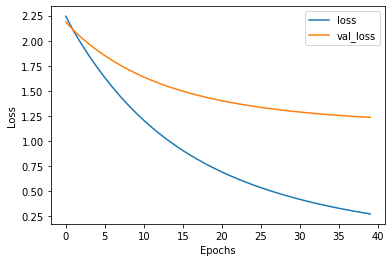

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

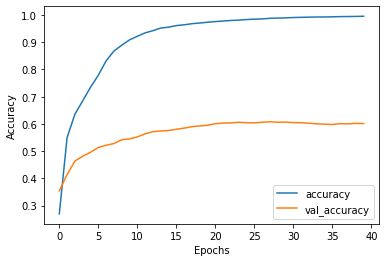

In [ ]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The plots above show that the validation loss decreases and the validation accuracy increases as expected, but they plateau around the 25th epoch when the model starts to overfit and no improvement is observed. Let's evaluate the model on the test set.

In [10]:
loaded_model = load_model('/content/drive/My Drive/Data Science Projects/text_classification_wiki/bow_best_model')
loaded_model.evaluate(X_test_bow, y_test_bow)

26/26 [==============================] - 0s 1ms/step - loss: 1.3015 - accuracy: 0.6080


[1.3015376329421997, 0.6080096960067749]

We obtain a final accuracy of 60%, which is quite good considering the simplicity of this model. Let's check the confusion matrix to have a closer look on the difficulties that the model had when classifying the samples.

In [14]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, label_encoder.inverse_transform(classes), rotation=90)
    plt.yticks(tick_marks, label_encoder.inverse_transform(classes))
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[81  3  6  2  2  3  0  9  6  2]
 [ 6 32  4  0  3  5  3  1  0  5]
 [ 7  0 45  2 11  2  5  6  6  1]
 [ 4  0  4 10  5  3  0  1  9  1]
 [ 9  3 13  4 40  6  1 18 12  2]
 [ 1  0  4  0  1 96  0  1  4  1]
 [ 0  0 15  0  3  0 18  1  0  2]
 [ 6  1 11  1 10  0  0 55  3  0]
 [16  1  4  5  7 17  0  7 39  0]
 [ 0  1  0  1  3  1  0  0  0 85]]


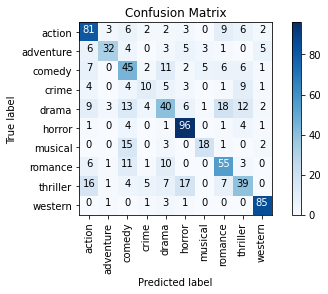

In [15]:
y_pred = loaded_model.predict(X_test_bow).argmax(axis=1)
cm = confusion_matrix(y_test_bow, y_pred)
plot_confusion_matrix(cm, list(range(num_classes)))

Let's focus on the misclassified samples. The first thing that calls our attention is that the comedy genre was frequently assigned to plots of other genres. The model confused comedy mainly with drama, musical and romance. Plots belonging to these two last genres usually have "positive" terms, so this mislabeling is quite reasonable. On the other hand, confusing drama with comedy seems a little bit odd, since drama movies tend to be more serious. Nevertheless, a brief research on movie genres shows that drama and comedy are very broad and there is even a sub-genre called comedy-drama. The model also confused romance with drama, which makes sense since many drama movies involve love and other related aspects. There was also mislabeling between action and thriller plots, which is reasonable considering that both genres have excitement and suspense as elements. Taking into account that this model is very simple and that the aim of this work is not going deep into movie genre analysis, the results were quite good. 

## Deep Learning models

In this section, a more complex/sophisticated approach will be used: word embeddings with deep learning models, namely a CNN and an LSTM. Machine learning models take arrays of numbers as input. Hence, when working with text, a strategy is needed to convert strings to numbers and word embeddings is one of the most common techniques to tackle this issue. The embeddings are a dense vector representation of each word in which similar words have similar representations/encodings. These encodings can be either learned during the training process or loaded from a pre-trained model. In this notebook, they are obtained by training a Keras Embedding layer which is added to the models.

In [ ]:
# The Tokenizer class creates a dictionary of unique words found in the plots and assigns an integer to each word. With this, we can use them as input to the models
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(plots))

# Getting the longest sentence. Every other sentence will be padded according to this maximum length
max_len = np.max([len(text.split()) for text in plots])

# Each plot will be converted to a list of integers (corresponding to each word in the plot)
X = tokenizer.texts_to_sequences(list(plots))
X = pad_sequences(X, maxlen=max_len)

# The same previously encoded labels (y) are used
print(X.shape, y.shape)

(8580, 2845) (8580,)


The data here is also split into three sets: train (70%), validation (20%) and test (10%).

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.12, random_state=0)

print(X_train.shape, X_val.shape, X_test.shape)

(6040, 2845) (1716, 2845) (824, 2845)


In [ ]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Total number of unique tokens (words) is', V)

Total number of unique tokens (words) is 52732


### CNN model

CNNs which perform 1D convolutions are one alternative when working with sequence data such as text. The convolution kernels slide across the time axis (across the words in a sentence) and perform the feature mapping. The kernel size determines how many words are considered in one convolution. 

The CNN model proposed in this notebook consists of an embedding layer followed by 3 1D convolution layers with a kernel of size 3. Each time that the number of feature maps is doubled, a Max Pooling layer is added in order to summarize the learned features and reduce computational cost as well as prevent overfitting. After the final convolution layer, the model has a Global Max Pooling layer to perform a global summarization of the data taking the max values across the feature maps (instead of using a fully connected layer), a dropout layer with a rate of 0.2 to amortize overfitting and finally a dense layer with softmax activation which gives the probabilities that each sample belongs to the existing classes. An embedding dimensionality of 100 was chosen.

In [ ]:
D = 100 # D is the embedding dimensionality. 
T = X_train.shape[1] # T is the sequence (sentence) length

num_classes = len(np.unique(y))

i = Input(shape=(T,)) 

x = Embedding(V+1, D)(i) 

x = Conv1D(32, 3, activation='relu')(x)
x = MaxPool1D()(x)

x = Conv1D(64, 3, activation='relu')(x)
x = MaxPool1D()(x)

x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPool1D()(x)

x = Dropout(0.2)(x)

x = Dense(num_classes, activation='softmax')(x)

model = Model(i, x)

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2845)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 2845, 100)         5273300   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2843, 32)          9632      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1421, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1419, 64)          6208      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 709, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 707, 128)          2470

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_filepath = '/content/drive/My Drive/Data Science Projects/text_classification_wiki/cnn_best_model'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

r = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=15, callbacks=[checkpoint_callback])

Epoch 1/15
189/189 [==============================] - ETA: 0s - loss: 2.2357 - accuracy: 0.1543INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/cnn_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/cnn_best_model/assets


189/189 [==============================] - 21s 111ms/step - loss: 2.2357 - accuracy: 0.1543 - val_loss: 2.0641 - val_accuracy: 0.2716
Epoch 2/15
189/189 [==============================] - ETA: 0s - loss: 1.8467 - accuracy: 0.3374INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/cnn_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/cnn_best_model/assets


189/189 [==============================] - 20s 106ms/step - loss: 1.8467 - accuracy: 0.3374 - val_loss: 1.6252 - val_accuracy: 0.4161
Epoch 3/15
189/189 [==============================] - ETA: 0s - loss: 1.2107 - accuracy: 0.5561INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/cnn_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/cnn_best_model/assets


189/189 [==============================] - 21s 111ms/step - loss: 1.2107 - accuracy: 0.5561 - val_loss: 1.5360 - val_accuracy: 0.4604
Epoch 4/15
189/189 [==============================] - 19s 99ms/step - loss: 0.6320 - accuracy: 0.7790 - val_loss: 1.8896 - val_accuracy: 0.4417
Epoch 5/15
189/189 [==============================] - 18s 97ms/step - loss: 0.3153 - accuracy: 0.8962 - val_loss: 2.3550 - val_accuracy: 0.4353
Epoch 6/15
189/189 [==============================] - 19s 98ms/step - loss: 0.1627 - accuracy: 0.9505 - val_loss: 2.7231 - val_accuracy: 0.4598
Epoch 7/15
189/189 [==============================] - 18s 96ms/step - loss: 0.1059 - accuracy: 0.9709 - val_loss: 3.1518 - val_accuracy: 0.4423
Epoch 8/15
189/189 [==============================] - 19s 101ms/step - loss: 0.0723 - accuracy: 0.9811 - val_loss: 3.5030 - val_accuracy: 0.4225
Epoch 9/15
189/189 [==============================] - 18s 97ms/step - loss: 0.0705 - accuracy: 0.9826 - val_loss: 3.4464 - val_accuracy: 0.4493
E

INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/cnn_best_model/assets


189/189 [==============================] - 20s 105ms/step - loss: 0.0544 - accuracy: 0.9854 - val_loss: 3.6793 - val_accuracy: 0.4615
Epoch 12/15
189/189 [==============================] - 19s 98ms/step - loss: 0.0506 - accuracy: 0.9873 - val_loss: 3.9881 - val_accuracy: 0.4563
Epoch 13/15
189/189 [==============================] - 19s 102ms/step - loss: 0.0376 - accuracy: 0.9909 - val_loss: 3.9169 - val_accuracy: 0.4598
Epoch 14/15
189/189 [==============================] - 18s 98ms/step - loss: 0.0333 - accuracy: 0.9944 - val_loss: 3.9274 - val_accuracy: 0.4476
Epoch 15/15
189/189 [==============================] - 19s 98ms/step - loss: 0.0326 - accuracy: 0.9930 - val_loss: 4.5996 - val_accuracy: 0.4283


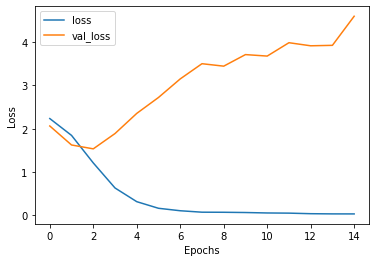

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

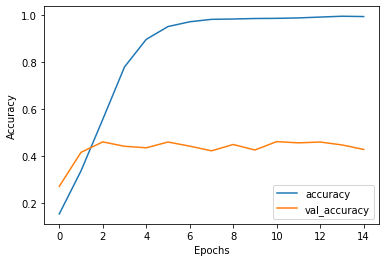

In [ ]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The plots show that the model overfits very quickly (around the third epoch) when the validation loss starts to increase and the validation accuracy practically plateaus around 45%. Still, a small improvement in the accuracy was observed on the 11th epoch. Let's evaluate the model using the test set.

In [ ]:
loaded_model = load_model('/content/drive/My Drive/Data Science Projects/text_classification_wiki/cnn_best_model')
loaded_model.evaluate(X_test, y_test)

26/26 [==============================] - 0s 17ms/step - loss: 3.5394 - accuracy: 0.4624


[3.5394339561462402, 0.4623786509037018]

The final accuracy is 46%, considerably lower than the one obtained in the BOW model. Let's check the confusion matrix.

Confusion matrix, without normalization
[[36  4  1 11  8  3  0  5 28  1]
 [ 4 27  0  1  7  2  0  0  3  4]
 [ 4  4 10  5 36  1  7  3  5  2]
 [ 9  9  2 19  5  3  2  1  8  0]
 [ 8  6 13  1 39  1  5  8 20  2]
 [ 2  7  1  0  6 69  0  0 21  3]
 [ 1  1  6  2 10  0 19  2  0  3]
 [14  0  6  0 35  0  2 43  8  3]
 [ 8  4  2  8 16 11  0  1 41  0]
 [ 0  3  0  1  1  1  0  0  2 78]]


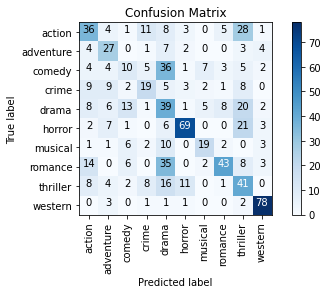

In [ ]:
y_pred = loaded_model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, list(range(num_classes)))

We observe that now drama was frequently assigned to plots of other genres. In particular, many comedy and romance plots were classified as drama. The confusion between comedy and drama is not really clear as mentioned previously, but considering that drama is a broad genre and the model's low accuracy, this interpretation is more difficult and not completely valid. Apart from some of the cases explained in the evaluation of the BOW model, the CNN model classified a considerable amount of action, drama and horror plots as thriller plots. These four genres have some elements in common such as excitement, suspense and a more serious atmosphere, so the model's interpretation is acceptable. Nevertheless, taking into account the low obtained accuracy, it is hard and questionable to justify the results, although the model seems to have learned some relevant features (horror and western movies are good examples).

### LSTM model

RNNs are the most common type of neural networks used in NLP. Their capability of modeling sequences and persisting information makes them perfectly suitable for working with NLP-related tasks such as speech recognition, language modeling and image captioning. The LSTM model used in this notebook consists of an embedding layer followed by one LSTM layer with 50 units, a Global Max Pooling layer and a dropout layer with a rate of 0.2 to amortize overfitting. The LSTM layer returns the output of each time step hidden state and the Global Max Pooling layer performs a summarization of these representations (outputs), instead of taking only the last hidden state output. It was observed that this slightly improved the validation accuracy. Finally, a dense layer with 10 units and softmax activation provides the final classification result. The chosen embedding dimensionality was 100 as in the CNN model.

In [ ]:
D = 100 
M = 50
T = X_train.shape[1]

num_classes = len(np.unique(y))

i = Input(shape=(T,)) 

x = Embedding(V+1, D)(i) 

x = LSTM(M, return_sequences=True)(x)

x = GlobalMaxPool1D()(x)

x = Dropout(0.2)(x)

x = Dense(num_classes, activation='softmax')(x)

model = Model(i, x)

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 2845)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 2845, 100)         5273300   
_________________________________________________________________
lstm (LSTM)                  (None, 2845, 50)          30200     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
Total params: 5,304,010
Trainable params: 5,304,010
Non-trainable params: 0
_________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_filepath = '/content/drive/My Drive/Data Science Projects/text_classification_wiki/lstm_best_model'

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

r = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=15, callbacks=[checkpoint_callback])

Epoch 1/15
189/189 [==============================] - ETA: 0s - loss: 2.1934 - accuracy: 0.1820INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/lstm_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/lstm_best_model/assets


189/189 [==============================] - 74s 390ms/step - loss: 2.1934 - accuracy: 0.1820 - val_loss: 1.9256 - val_accuracy: 0.3473
Epoch 2/15
189/189 [==============================] - ETA: 0s - loss: 1.6599 - accuracy: 0.4245INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/lstm_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/lstm_best_model/assets


189/189 [==============================] - 72s 381ms/step - loss: 1.6599 - accuracy: 0.4245 - val_loss: 1.5651 - val_accuracy: 0.4586
Epoch 3/15
189/189 [==============================] - ETA: 0s - loss: 1.1963 - accuracy: 0.5848INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/lstm_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Data Science Projects/text_classification_wiki/lstm_best_model/assets


189/189 [==============================] - 71s 373ms/step - loss: 1.1963 - accuracy: 0.5848 - val_loss: 1.4810 - val_accuracy: 0.4837
Epoch 4/15
189/189 [==============================] - 65s 343ms/step - loss: 0.8513 - accuracy: 0.7250 - val_loss: 1.5654 - val_accuracy: 0.4779
Epoch 5/15
189/189 [==============================] - 65s 343ms/step - loss: 0.6585 - accuracy: 0.8099 - val_loss: 1.8108 - val_accuracy: 0.4388
Epoch 6/15
189/189 [==============================] - 65s 342ms/step - loss: 0.4239 - accuracy: 0.8975 - val_loss: 1.6938 - val_accuracy: 0.4790
Epoch 7/15
189/189 [==============================] - 65s 343ms/step - loss: 0.2762 - accuracy: 0.9354 - val_loss: 1.7392 - val_accuracy: 0.4674
Epoch 8/15
189/189 [==============================] - 65s 342ms/step - loss: 0.1807 - accuracy: 0.9672 - val_loss: 1.9204 - val_accuracy: 0.4732
Epoch 9/15
189/189 [==============================] - 65s 342ms/step - loss: 0.1598 - accuracy: 0.9684 - val_loss: 1.9727 - val_accuracy: 0.4

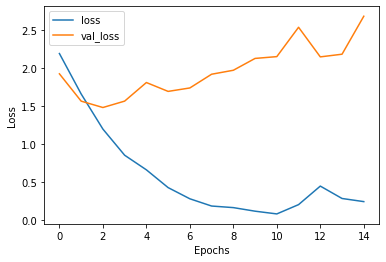

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

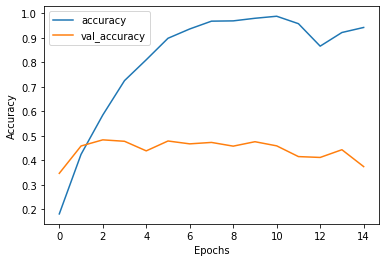

In [ ]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Just as with the CNN model, the LSTM model overfits very quickly (around the third epoch, when the last improvement in the validation accuracy was observed). Let's evaluate the model on the test set to get the final accuracy.


In [ ]:
loaded_model = load_model('/content/drive/My Drive/Data Science Projects/text_classification_wiki/lstm_best_model')
loaded_model.evaluate(X_test, y_test)

26/26 [==============================] - 3s 127ms/step - loss: 1.4202 - accuracy: 0.4879


[1.4201701879501343, 0.48786407709121704]

The final accuracy is 49%, just slightly better than the CNN model.

Confusion matrix, without normalization
[[48  0  4 11  1  5  0  9 16  3]
 [ 7  7  5  1  4  6  0  0  9  9]
 [ 3  2 50  3  3  1  0  7  8  0]
 [18  0  6 20  1  3  0  1  7  2]
 [ 8  1 43  4 10  1  1 15 15  5]
 [ 1  0  3  4  0 87  0  1 12  1]
 [ 2  1 32  0  1  0  6  1  0  1]
 [ 7  0 30  0  4  1  0 65  3  1]
 [ 7  1 12 13  2 24  0  3 29  0]
 [ 1  2  1  1  1  0  0  0  0 80]]


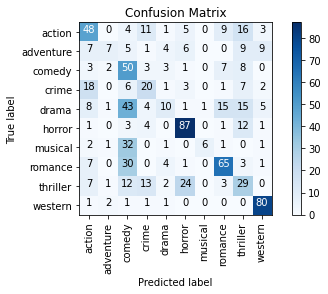

In [ ]:
y_pred = loaded_model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, list(range(num_classes)))

In this model, the comedy genre was once again frequently assigned to plots belonging to other genres. It is relevant to remember that comedy and drama are in the 5 most frequent genres of the dataset after preprocessing, so a bias towards comedy and drama is expected. Although horror and action movies are as frequent as comedy and drama, their plots seem to have words which are more specific and better describe the essence of each genre. The model showed better results in the classification of action, comedy, horror and romance plots when compared to the CNN model. Therefore, it is reasonable to affirm that LSTM's   capacity of modeling sequences and capturing temporal dependencies was a reason for the improvement in the accuracy.

# Binary classification

For multiclass classification we had the class imbalance problem, which was amortized by sampling a smaller amount of plots belonging to the most frequent genres (drama and comedy). However, the amount of data (which was already small) was considerably reduced with this process, so the task was impaired and the results were not satisfying. Now a binary classification between drama and comedy will be experimented using the same models as in the previous task. This binary classification is interesting because the two most frequente genres will be used and it was observed that the previous models seemed to have difficulty when distinguishing between both.

In [ ]:
df_preprocessed_binary = pd.read_csv('/content/drive/My Drive/Data Science Projects/text_classification_wiki/df_preprocessed_binary.csv')
df_preprocessed_binary.head()

,plot,genre
0,film famili move suburb hope quiet life thing ...,comedy
1,head basebal game nearbi ballpark sport fan mr...,comedy
2,plot black woman go dentist toothach given lau...,comedy
3,beauti summer day father mother take daughter ...,drama
4,thug accost girl leav workplac man rescu her t...,drama


Checking the genre distribution and the plots column.

In [ ]:
df_preprocessed_binary['genre'].value_counts()

drama     5964
comedy    4379
Name: genre, dtype: int64

In [ ]:
plots = df_preprocessed_binary['plot'].values
plots

array(['film famili move suburb hope quiet life thing start go wrong wife get violent start throw crockeri lead arrest',
       'head basebal game nearbi ballpark sport fan mr brown drink sever highbal cocktail arriv ballpark watch game becom inebri game appear revers player run base backward basebal fli back pitcher hand game over mr brown escort home one friend arriv brown hous encount wife becom furiou friend proce physic assault him believ respons husband sever',
       'plot black woman go dentist toothach given laugh ga way walk home situat cant stop laugh everyon meet catch laughter her includ vendor polic offic',
       ...,
       'film open senegales boy name khadim told littl sister aya fallen rock parent two kid debat whether take aya hospit sinc hospit white khadim aya famili black parent quickli decid go white hospit hospit far away hope find car give lift car white coupl tour lake retba area actual pass husband tell wife listen tour guid told never stop might rob so whit

Although the class imbalance problem still exists, it is not very expressive and the distribution is quite even considering that this is "real data". Now let's encode the genres (comedy and drama) with integers.

In [ ]:
y = df_preprocessed_binary['genre'].values
label_encoder = LabelEncoder()
label_encoder.fit(list(y))

y = label_encoder.transform(list(y))
print('labels:', np.unique(y))
print('corresponding classes:', list(label_encoder.inverse_transform(np.unique(y))))

labels: [0 1]
corresponding classes: ['comedy', 'drama']


## BOW Model

In [ ]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df_preprocessed_binary['plot'])
tfidf_matrix.sort_indices() 

print('tf-idf matrix shape:', tfidf_matrix.shape) # shape: (documents, words)

tf-idf matrix shape: (10343, 56500)


In [ ]:
X_train_bow, X_val_bow, y_train_bow, y_val_bow = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=0)
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_train_bow, y_train_bow, test_size=0.12, random_state=0, shuffle=False)

print(X_train_bow.shape, X_val_bow.shape, X_test_bow.shape)

(7281, 56500) (2069, 56500) (993, 56500)


The only changes in the model when comparing to the BOW model in the multiclass classification were the output layer (which now has only a single neuron with sigmoid activation function) and the loss function (now the binary cross-entropy is used).

In [ ]:
T = tfidf_matrix.shape[1] 
i = Input(shape=(T,)) 
x = Dense(1, activation='sigmoid')(i)

model = Model(i, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_filepath = './bow_best_model_binary'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

r = model.fit(X_train_bow.todense(), y_train_bow, validation_data=(X_val_bow.todense(), y_val_bow), batch_size=32, epochs=40, callbacks=[checkpoint_callback])

Train on 7281 samples, validate on 2069 samples
Epoch 1/40
7281/7281 [==============================] - 3s 423us/sample - loss: 0.6797 - accuracy: 0.5770 - val_loss: 0.6711 - val_accuracy: 0.5660
Epoch 2/40
7281/7281 [==============================] - 3s 371us/sample - loss: 0.6524 - accuracy: 0.5796 - val_loss: 0.6570 - val_accuracy: 0.5669
Epoch 3/40
7281/7281 [==============================] - 3s 381us/sample - loss: 0.6293 - accuracy: 0.5973 - val_loss: 0.6441 - val_accuracy: 0.5863
Epoch 4/40
7281/7281 [==============================] - 3s 377us/sample - loss: 0.6078 - accuracy: 0.6491 - val_loss: 0.6320 - val_accuracy: 0.6172
Epoch 5/40
7281/7281 [==============================] - 3s 373us/sample - loss: 0.5875 - accuracy: 0.7139 - val_loss: 0.6207 - val_accuracy: 0.6559
Epoch 6/40
7281/7281 [==============================] - 3s 368us/sample - loss: 0.5684 - accuracy: 0.7752 - val_loss: 0.6103 - val_accuracy: 0.6810
Epoch 7/40
7281/7281 [==============================] - 3s 380us

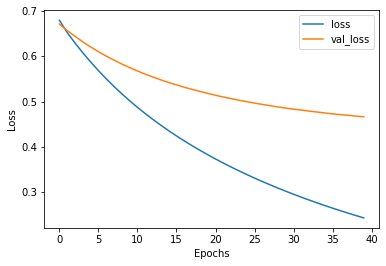

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

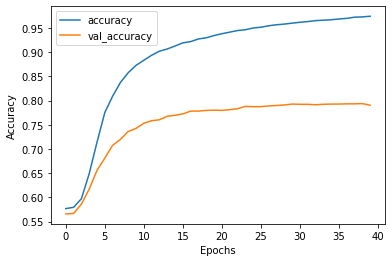

In [ ]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The plots show that the model performed much better than the BOW model in the multiclass classification, with a validation accuracy of around 77%. It is even reasonable to affirm that the model could have been trained for more epochs. However, in order to keep the same traning parameters as in the previous task and to avoid overfitting, the number of epochs for this model was kept the same. Let's evaluate the model on the test set and get the final accuracy.

In [ ]:
loaded_model = load_model('./bow_best_model_binary')
loaded_model.evaluate(X_test_bow.todense(), y_test_bow)

993/993 [==============================] - 0s 319us/sample - loss: 0.4486 - accuracy: 0.8238


[0.4485940293362974, 0.82376635]

The final accuracy is 82% which is considerably higher than the 61% obtained in the BOW model for multiclass classification. Let's check the confusion matrix.

Confusion matrix, without normalization
[[306 107]
 [ 68 512]]


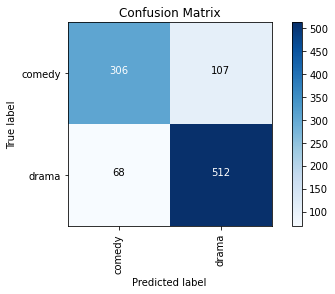

In [ ]:
y_pred = loaded_model.predict(X_test_bow.todense())
cm = confusion_matrix(y_test_bow, np.where(y_pred > 0.5, 1, 0))
plot_confusion_matrix(cm, list(range(2)))

Looking at the secondary diagonal, the matrix shows that it was easier for the model to correctly classify drama plots than comedy plots. The result is pretty good for a simple BOW model, mainly considering the relatively small amount of used data.

## Deep Learning models

In [ ]:
# The Tokenizer class creates a dictionary of unique words found in the plots and assigns an integer to each word. With this, we can use them as input to the models
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(plots))

# Getting the longest sentence. Every other sentence will be padded according to this maximum length
max_len = np.max([len(text.split()) for text in plots])

# Each plot will be converted to a list of integers (corresponding to each word in the plot)
X = tokenizer.texts_to_sequences(list(plots))
X = pad_sequences(X, maxlen=max_len)

print(X.shape, y.shape)

(10343, 1511) (10343,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.12, random_state=0)

print(X_train.shape, X_val.shape, X_test.shape)

(7281, 1511) (2069, 1511) (993, 1511)


In [ ]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Total number of unique tokens (words) is', V)

Total number of unique tokens (words) is 56528


### CNN model

Besides the changes in the output layer and loss function (as mentioned in the BOW model section), for this model the number of training epochs was reduced to 5 due to overfitting.

In [ ]:
D = 100 
T = X_train.shape[1]

num_classes = len(np.unique(y))

i = Input(shape=(T,)) 

x = Embedding(V+1, D)(i) 

x = Conv1D(32, 3, activation='relu')(x)
x = MaxPool1D()(x)

x = Conv1D(64, 3, activation='relu')(x)
x = MaxPool1D()(x)

x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPool1D()(x)

x = Dropout(0.2)(x)

x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1511)]            0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 1511, 100)         5652900   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1509, 32)          9632      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 754, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 752, 64)           6208      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 376, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 374, 128)          2470

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_filepath = './cnn_best_model_binary'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

r = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=5, callbacks=[checkpoint_callback])

Train on 7281 samples, validate on 2069 samples
Epoch 1/5
7281/7281 [==============================] - 22s 3ms/sample - loss: 0.6589 - accuracy: 0.6058 - val_loss: 0.5613 - val_accuracy: 0.7177
Epoch 2/5
7281/7281 [==============================] - 20s 3ms/sample - loss: 0.4180 - accuracy: 0.8154 - val_loss: 0.5488 - val_accuracy: 0.7303
Epoch 3/5
7281/7281 [==============================] - 20s 3ms/sample - loss: 0.1130 - accuracy: 0.9598 - val_loss: 0.7385 - val_accuracy: 0.7438
Epoch 4/5
7281/7281 [==============================] - 19s 3ms/sample - loss: 0.0286 - accuracy: 0.9931 - val_loss: 1.1430 - val_accuracy: 0.7371
Epoch 5/5
7281/7281 [==============================] - 19s 3ms/sample - loss: 0.0117 - accuracy: 0.9977 - val_loss: 1.1985 - val_accuracy: 0.7100


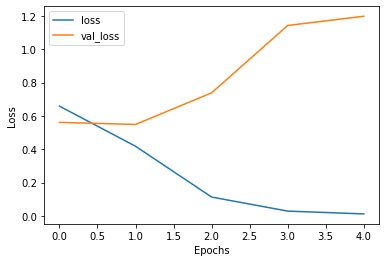

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

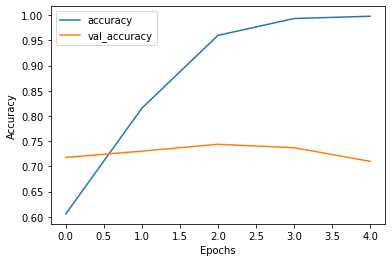

In [ ]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The model overfits and presents a good validation accuracy very quickly, right after the first epoch (hence the decrease in the number of epochs). Since binary classification is an easier task than multiclass classification and that a higher amount of data is used, it was expected that a deep learning model would present good results within few epochs. Let's evaluate the model and get the final accuracy. 

In [ ]:
loaded_model = load_model('./cnn_best_model_binary')
loaded_model.evaluate(X_test, y_test)

993/993 [==============================] - 0s 379us/sample - loss: 0.7425 - accuracy: 0.7321


[0.7425142218474174, 0.73212487]

The final accuracy is 73%, relatively worse than the one obtained with the BOW model (79%). If we compare to the multiclass classification, this difference is much lower (we had 60% for the BOW model and 46% for the CNN model), which indicates that the complexity of deep learning models contribute significantly to this task (the amount of data has increased and they benefit from it, this should be considered too).  

Confusion matrix, without normalization
[[297 114]
 [152 430]]


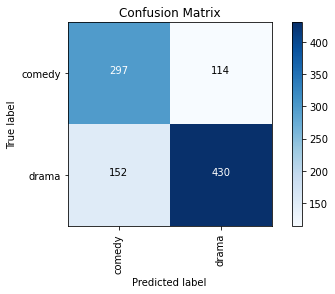

In [ ]:
y_pred = loaded_model.predict(X_test)
cm = confusion_matrix(y_test, np.where(y_pred > 0.5, 1,0))
plot_confusion_matrix(cm, list(range(num_classes)))

Analyzing the secondary diagonal, the confusion matrix shows that it was easier for the model to classify comedy plots than drama plots (as opposed to the situation observed in the BOW model), but the difference in the number of mislabeled samples is not really meaningful.

### LSTM model

For this model, the same changes of the CNN model were applied.

In [ ]:
D = 100 
M = 50
T = X_train.shape[1]

num_classes = len(np.unique(y))

i = Input(shape=(T,)) 

x = Embedding(V+1, D)(i) 

x = LSTM(M, return_sequences=True)(x)

x = GlobalMaxPool1D()(x)

x = Dropout(0.2)(x)

x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1511)]            0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 1511, 100)         5652900   
_________________________________________________________________
lstm_6 (LSTM)                (None, 1511, 50)          30200     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 50)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 5,683,151
Trainable params: 5,683,151
Non-trainable params: 0
_________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_filepath = './lstm_best_model_binary'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

r = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=5, callbacks=[checkpoint_callback])

Train on 7281 samples, validate on 2069 samples
Epoch 1/5
7281/7281 [==============================] - 63s 9ms/sample - loss: 0.6225 - accuracy: 0.6524 - val_loss: 0.5136 - val_accuracy: 0.7535
Epoch 2/5
7281/7281 [==============================] - 59s 8ms/sample - loss: 0.3442 - accuracy: 0.8584 - val_loss: 0.5106 - val_accuracy: 0.7719
Epoch 3/5
7281/7281 [==============================] - 55s 8ms/sample - loss: 0.1386 - accuracy: 0.9529 - val_loss: 0.6108 - val_accuracy: 0.7569
Epoch 4/5
7281/7281 [==============================] - 55s 8ms/sample - loss: 0.0749 - accuracy: 0.9782 - val_loss: 0.5923 - val_accuracy: 0.7477
Epoch 5/5
7281/7281 [==============================] - 55s 8ms/sample - loss: 0.0479 - accuracy: 0.9857 - val_loss: 0.8996 - val_accuracy: 0.7511


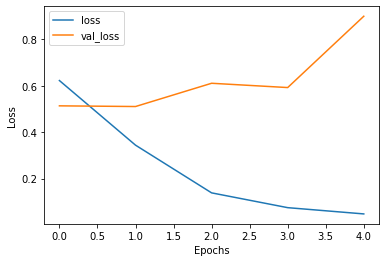

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

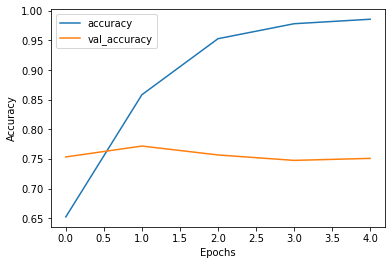

In [ ]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Just like the CNN model, the LSTM model overfits and presents a good validation accuracy very quickly, right after the first epoch (hence the decrease in the number of epochs as well). However, a small improvement in the validation accuracy was observed. Let's evaluate the model and get the final accuracy. 

In [ ]:
loaded_model = load_model('./lstm_best_model_binary')
loaded_model.evaluate(X_test, y_test)

993/993 [==============================] - 7s 7ms/sample - loss: 0.5115 - accuracy: 0.7684


[0.51154983941792, 0.7683787]

The final accuracy is 77%, slightly better than the CNN model (73%) and very close to the BOW model (82%). As in the multiclass classification, the LSTM model showed higher accuracy than the CNN model, which supports the idea that LSTMs are generally a better option when dealing with text and other sequence data.

Confusion matrix, without normalization
[[286 125]
 [105 477]]


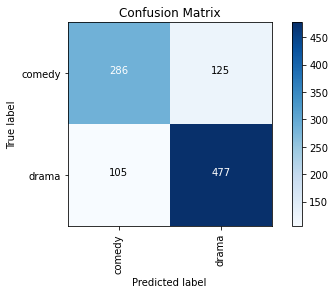

In [ ]:
y_pred = loaded_model.predict(X_test)
cm = confusion_matrix(y_test, np.where(y_pred > 0.5, 1, 0))
plot_confusion_matrix(cm, list(range(num_classes)))

Analyzing the secondary diagonal, the confusion matrix shows that it was easier for the model to correctly classify drama plots than comedy plots (as opposed to the situation observed in the CNN model), but once again the difference in the number of mislabeled samples is not meaningful and even smaller than in the CNN model.

## Conclusion and future work
Let's first analyze the multiclass classification task. 

The BOW model showed the best accuracy for this task, which was quite unexpected since the model is very simple. One possible explanation for the lower accuracies in the deep learning models is the small amount of provided data (8500 samples, still divided between train, validation and test sets). It has already been verified in many works that the amount of data used for training is of ultimate importance in the performance of deep learning models. Besides, class imbalance is also an issue. The most frequent genres have twice the number of samples of the least frequent genres, so that also jeopardizes the classification performance of both types of models.  

Nevertheless, the bag of words approach has some known considerable limitations: since the representation is sparse, it implies more computational costs (memory and processing time) and makes it more difficult for the models to capture the essential information in such high dimensionality data. Another problem with this approach is that it does not take into consideration word order. Hence, the model has no notion of context or semantics, thus making it unaware of the relationship between words and impairing the interpretation.  

It is worth indicating that action, horror, romance and western plots seem to have words which properly describe their respective genres and make the models distinguish them well from the plots of other genres.

Now let's analyze the binary classification task. As expected, the models performed much better than in the previous task, since the number of possible classes is considerably reduced. In addition, around 2000 more samples were used when taking all comedy and drama plots. The BOW model still showed better accuracy than the deep learning models. However, the difference between accuracies was smaller in this task. As the amount of data increases, it is expected that the deep learning models eventually outperform a BOW model due to their more sophisticated feature learning and generalization capabilities. Furthermore, with more data deeper models can be used, which allows the extraction of more complex features.

Even though changes in the models' structure and training parameters were experimented, none of them showed significant improvement (or no improvement at all) in the results. Here are some of these changes:
- Lower (fixed) learning rates
- Learning rate scheduler
- Bidirectional LSTM
- CNN with more layers or filter maps
- Stacked LSTM layers

As future work, some indications are:
- Analyze the plots of drama and comedy in an attempt to understand the observed confusion between these genres in multiclass classification;
- Experiment with different preprocessing techniques (e.g., lemmatization, add more/other stopwords, deeper analysis of the plots to remove useless words such as name of actors/actresses);
- Perform the same classification tasks using another dataset (preferably with more data) and verify whether deep learning models in fact outperform a simple BOW model.
